In [1]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(DESeq2)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: data.table

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   4.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::l

### DESeq2 test results

In [109]:
res<- readRDS("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/res_dds.rds")

In [110]:
head(res)

log2 fold change (MLE): Cluster 2 vs 1 
Wald test p-value: Cluster 2 vs 1 
DataFrame with 6 rows and 6 columns
       baseMean log2FoldChange     lfcSE      stat      pvalue        padj
      <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
ASV1   1069.296       -7.49343   1.17619  -6.37092 1.87892e-10 4.95466e-09
ASV3   1704.947       -8.74122   1.24825  -7.00280 2.50890e-12 6.96837e-11
ASV5    300.488       -9.08546   1.56753  -5.79603 6.79039e-09 1.65534e-07
ASV8    132.478        6.40397   1.57537   4.06505 4.80220e-05 8.07556e-04
ASV9   2118.720      -10.33846   1.42735  -7.24312 4.38479e-13 1.23815e-11
ASV10    51.916       -3.95480   1.85751  -2.12908 3.32474e-02 1.93746e-01

In [112]:
res_df <- as.data.frame(res)
res_df$EnrichedIn <- ifelse(res_df$log2FoldChange > 0, "Cluster2", "Cluster1")
class(res_df)

[1] "data.frame"

In [113]:
nrow(res_df)
length(res_df$EnrichedIn)
table(res_df$EnrichedIn)

[1] 6787

[1] 6787


Cluster1 Cluster2 
    4557     2230 

#### ^ making a new df from res with a new column IDing cluster 1 and cluster 2, based on logFC
- fold change is the ratio between the two groups
- FC= (Expression of X in grp2)/(expression of X in grp 1)
- FC=2 logFC=1
- FC=4 logFC=2
- FC=.5 logFC=-1

### DESeq2 volcano
- most statistically significant asvs will be towards the top bc they have the lowest p-values
- EnhancedVolcano will only attempt to label genes that pass the thresholds that you set for statistical significance, i.e., ‘pCutoff’ and ‘FCcutoff’

In [25]:
library(EnhancedVolcano)

Loading required package: ggrepel



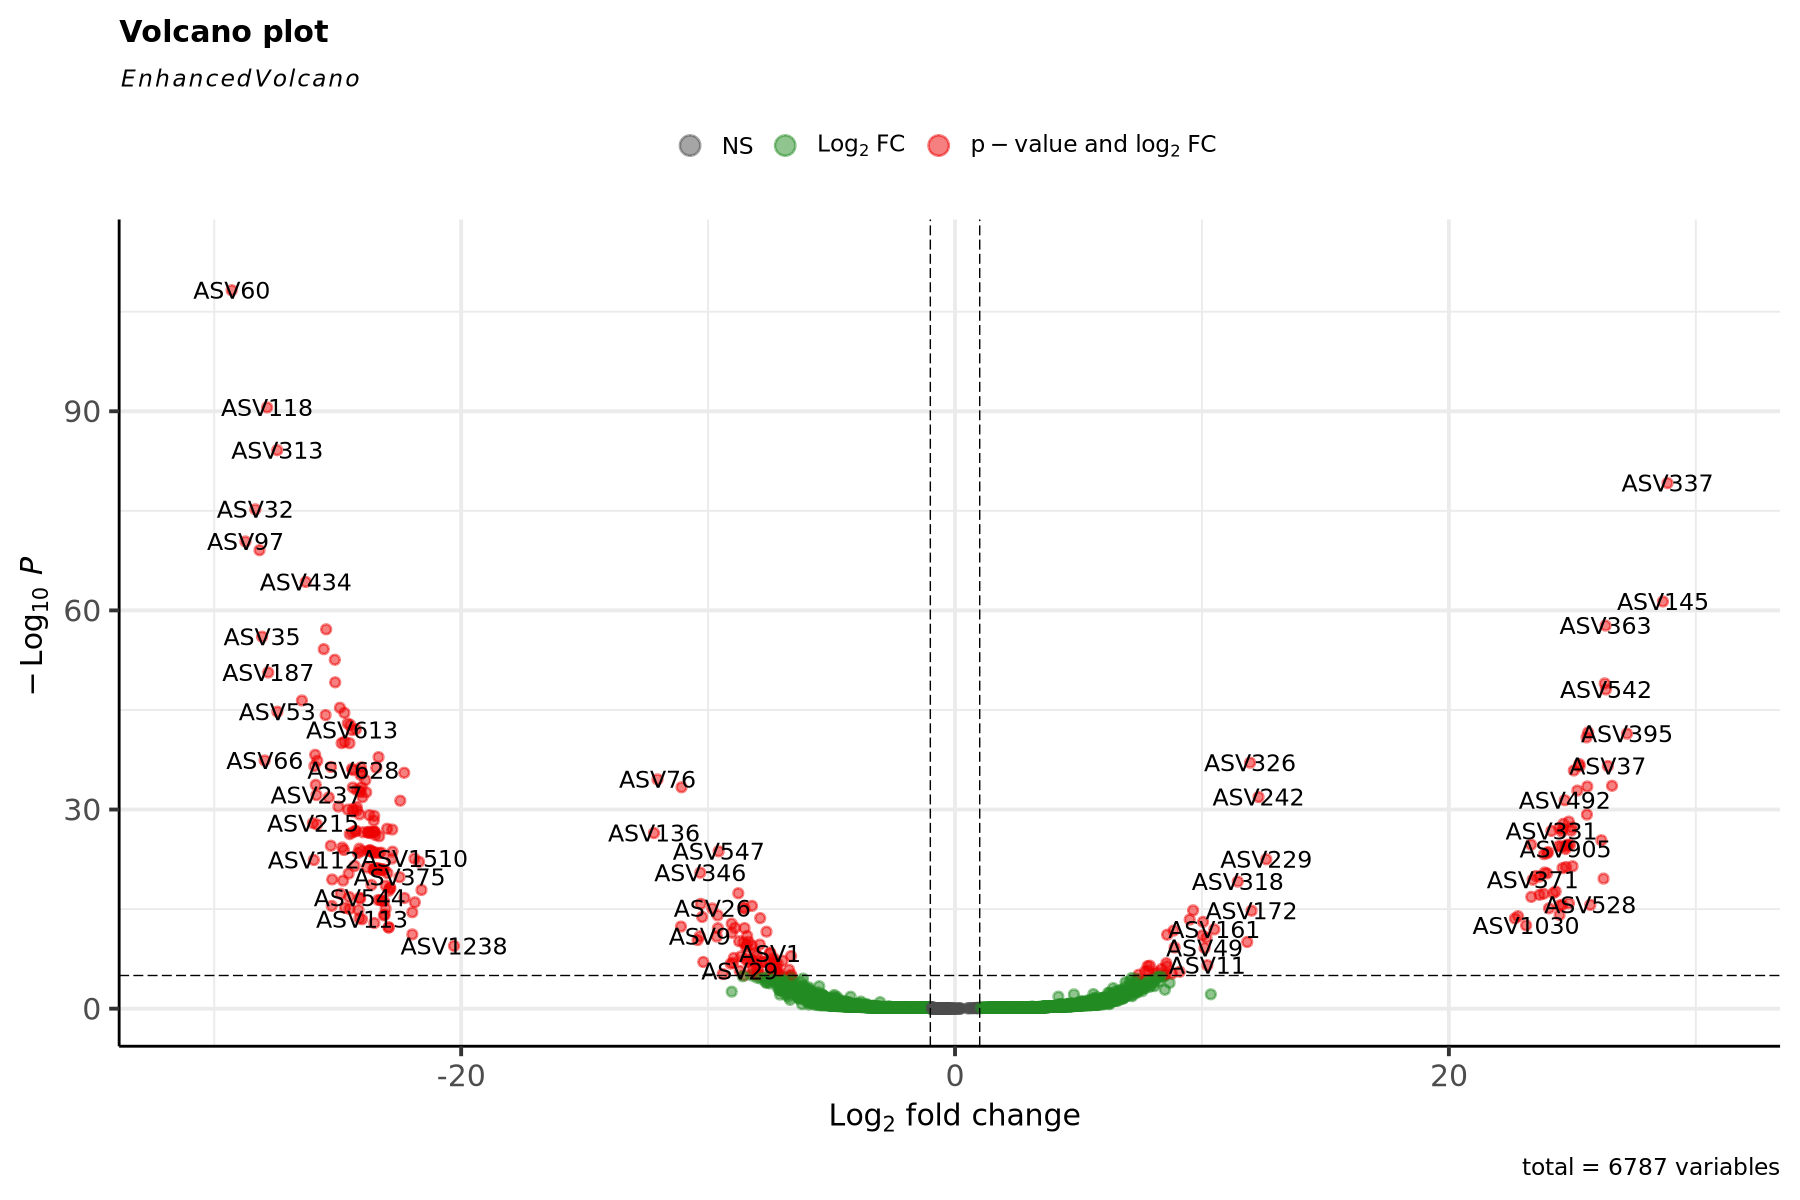

In [50]:
 #first attempt without ASV short names is unreadable
#with ASV short names
#res and sig_cluster look the same
    EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'padj')

### Interperting volcano plot
- positve LogFC indicates more expression of ASVs in cluster 2
- the higher the -logP the more signifcant

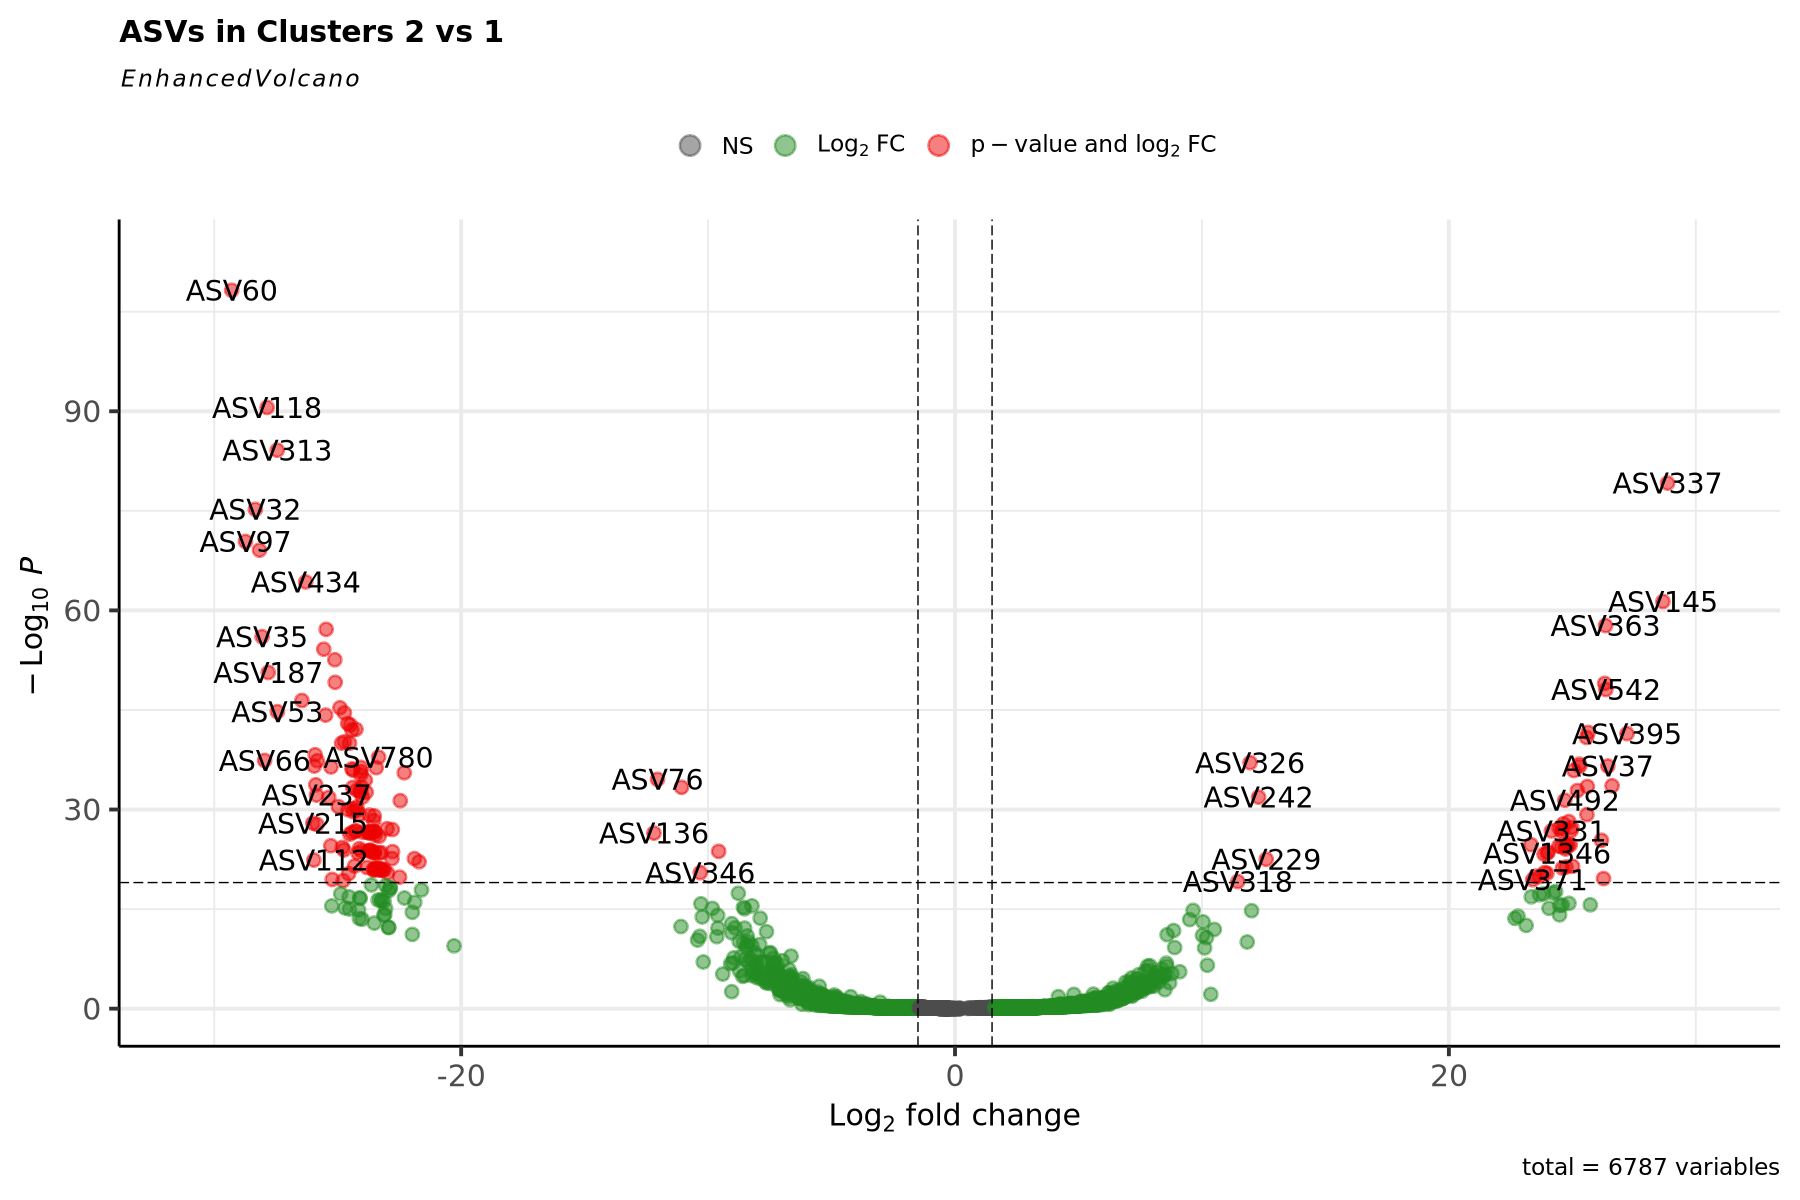

In [59]:
    EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'padj',
    title = 'ASVs in Clusters 2 vs 1',
    pCutoff =  10e-20, #p value=0.01
    FCcutoff = 1.5,
    pointSize = 3.0,
    labSize = 6.0,
    legendPosition = 'right',
    legendLabSize = 14,
    legendIconSize = 4.0,)

#### custom volcano plot

In [85]:
head(res_df)
nrow(res_df)            # should be 6787
length(res_df$EnrichedIn)  # should also be 6787
table(res_df$EnrichedIn)   # should show two levels

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,EnrichedIn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ASV1,1069.29562,-7.493426,1.176191,-6.370924,1.878923e-10,4.954655e-09,Cluster1
ASV3,1704.94700,-8.741219,1.248246,-7.002804,2.508901e-12,6.968370e-11,Cluster1
ASV5,300.48775,-9.085456,1.567531,-5.796028,6.790386e-09,1.655340e-07,Cluster1
ASV8,132.47777,6.403973,1.575373,4.065051,4.802197e-05,8.075556e-04,Cluster2
ASV9,2118.72005,-10.338458,1.427349,-7.243120,4.384786e-13,1.238154e-11,Cluster1
ASV10,51.91596,-3.954799,1.857513,-2.129083,3.324742e-02,1.937459e-01,Cluster1


[1] 6787

[1] 6787


Cluster1 Cluster2 
    4557     2230 

In [86]:
str(res_df$EnrichedIn)      # Should be a character or factor vector, length 6787
unique(res_df$EnrichedIn)   # Should show only "Cluster 1" and "Cluster 2"
any(is.na(res_df$EnrichedIn))  # Should be FALSE

 chr [1:6787] "Cluster1" "Cluster1" "Cluster1" "Cluster2" "Cluster1" ...


[1] "Cluster1" "Cluster2"

[1] FALSE

In [88]:
 # create custom key-value pairs for different cell-types
  # this can be achieved with nested ifelse statements
keyvals.shape <- ifelse(
  res_df$EnrichedIn == "Cluster1", 17,
  ifelse(res_df$EnrichedIn == "Cluster2", 64, 3)
)

keyvals.shape[is.na(keyvals.shape)] <- 3

names(keyvals.shape)[keyvals.shape == 17] <- "Cluster1"
names(keyvals.shape)[keyvals.shape == 64] <- "Cluster2"

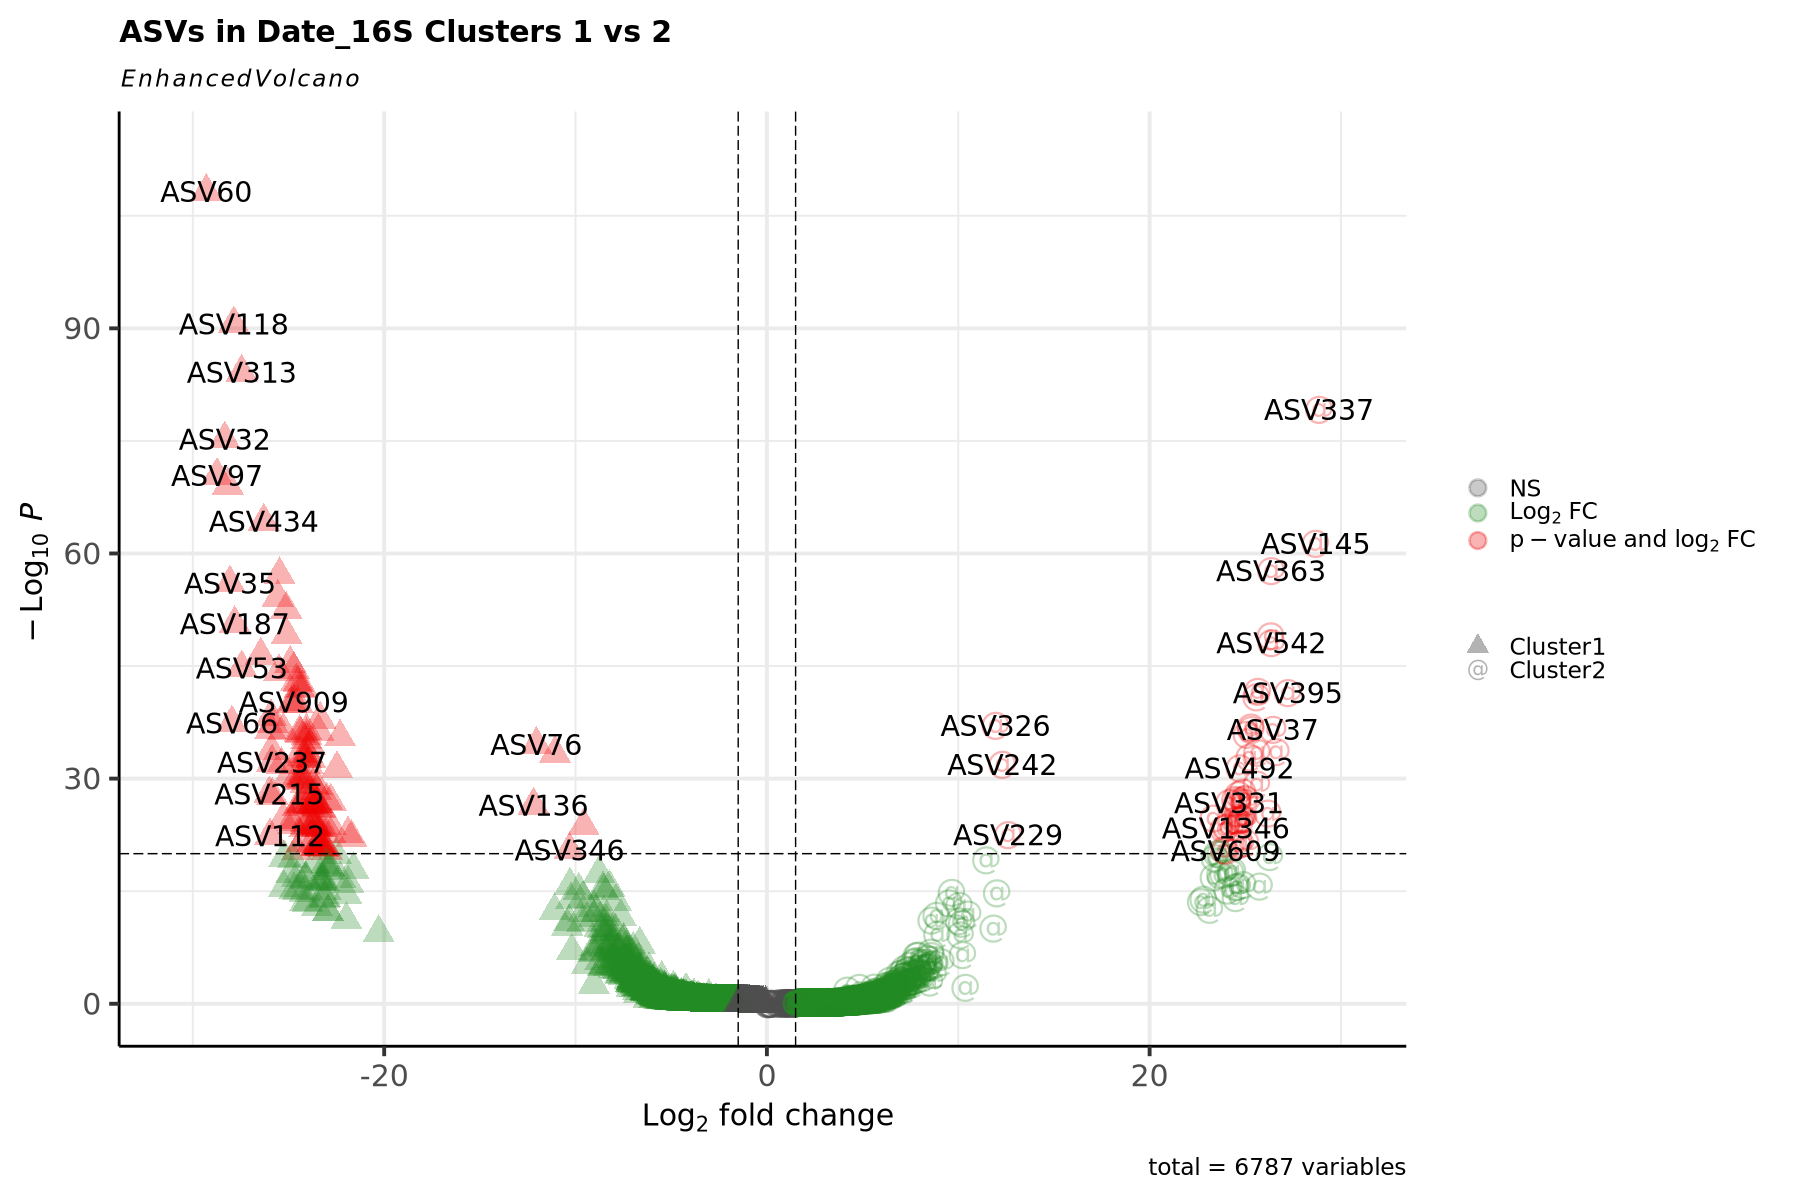

In [98]:
# Step 4: Volcano plot
EnhancedVolcano(res_df,
    lab = rownames(res_df),
    x = 'log2FoldChange',
    y = 'padj',
    title = 'ASVs in Date_16S Clusters 1 vs 2',
    pCutoff = 1e-20,
    FCcutoff = 1.5,
    pointSize = 6.0,
    colAlpha = 0.3,
    labSize = 6.0,
    legendPosition = 'right',
    legendLabSize = 14,
    legendIconSize = 4.0,
shapeCustom = keyvals.shape,
    colCustom = NULL)

In [95]:
write.csv(as.data.frame(res), "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/date16S_clusters_deseq.csv")

In [94]:
head(res)

log2 fold change (MLE): Cluster 2 vs 1 
Wald test p-value: Cluster 2 vs 1 
DataFrame with 6 rows and 7 columns
       baseMean log2FoldChange     lfcSE      stat      pvalue        padj
      <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
ASV1   1069.296       -7.49343   1.17619  -6.37092 1.87892e-10 4.95466e-09
ASV3   1704.947       -8.74122   1.24825  -7.00280 2.50890e-12 6.96837e-11
ASV5    300.488       -9.08546   1.56753  -5.79603 6.79039e-09 1.65534e-07
ASV8    132.478        6.40397   1.57537   4.06505 4.80220e-05 8.07556e-04
ASV9   2118.720      -10.33846   1.42735  -7.24312 4.38479e-13 1.23815e-11
ASV10    51.916       -3.95480   1.85751  -2.12908 3.32474e-02 1.93746e-01
       EnrichedIn
      <character>
ASV1    Cluster 1
ASV3    Cluster 1
ASV5    Cluster 1
ASV8    Cluster 2
ASV9    Cluster 1
ASV10   Cluster 1

### what does this plot do??

In [ ]:
scale_fill_discrete <- function(palname = "Set3", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sig_cluster$log2FoldChange, sig_cluster$Phylum, function(x) max(x))
x = sort(x, TRUE)
sig_cluster$Phylum = factor(as.character(sig_cluster$Phylum), levels=names(x))
# Genus order
x = tapply(sig_cluster$log2FoldChange, sig_cluster$Family, function(x) max(x))
x = sort(x, TRUE)
sig_cluster$Family = factor(as.character(sig_cluster$Family), levels=names(x))
ggplot(sig_cluster, aes(x=Family, y=log2FoldChange, color=Phylum)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))